Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Optimized Random Forest RMSE: 8584.2508
Optimized Random Forest R^2: 0.8055


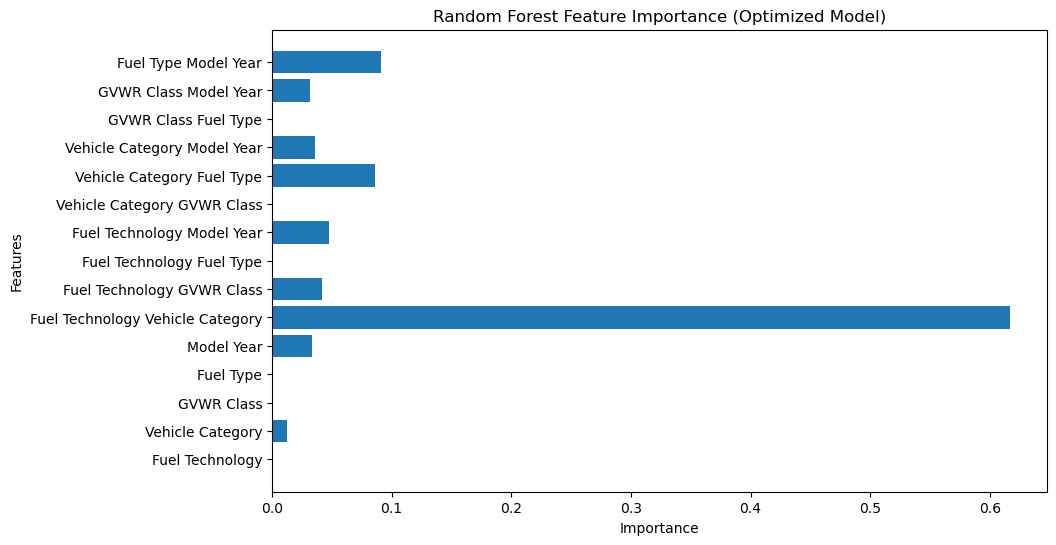

Best Hyperparameters found by GridSearchCV:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Cross-validated RMSE: 373628456.0236


In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

# Load the datasets
train_data = pd.read_excel(r'C:\Users\HP\Downloads\training.xlsx', sheet_name='Sheet1')
scoring_data = pd.read_excel(r'C:\Users\HP\Downloads\scoring.xlsx', sheet_name='Sheet1')

# Define features and target (use all the available features)
features = ['Fuel Technology', 'Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year']
target = 'Vehicle Population'

# Function to handle mixed data types and missing values
def clean_column(data, column_name):
    data[column_name] = data[column_name].astype(str)
    data[column_name] = data[column_name].fillna('Unknown')

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in features:
    clean_column(train_data, col)
    clean_column(scoring_data, col)
    train_data[col] = label_encoder.fit_transform(train_data[col])
    scoring_data[col] = label_encoder.transform(scoring_data[col])  # Use the same encoder for scoring data

# Prepare the training and testing sets
X_train = train_data[features]
y_train = train_data[target]
X_test = scoring_data[features]
y_test = scoring_data[target]

# Add Polynomial Features (interaction terms, degree 2)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize Random Forest Model
rf_model = RandomForestRegressor(random_state=42)

# Set up a larger hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Test more trees
    'max_depth': [5, 10, 15, 20],           # More varied depths
    'min_samples_split': [2, 5, 10],        # Try varying sample splits
    'min_samples_leaf': [1, 2, 4],          # Varying leaf sizes
    'max_features': ['sqrt', 'log2', None]  # Corrected: 'auto' replaced with 'sqrt', 'log2', or None
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)  # Using polynomial features

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Step 1: Train the best Random Forest model
best_rf_model.fit(X_train_poly, y_train)

# Step 2: Make predictions and evaluate performance on the test data
y_pred = best_rf_model.predict(X_test_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized Random Forest RMSE: {rmse:.4f}")
print(f"Optimized Random Forest R^2: {r2:.4f}")

# Step 3: Feature Importance Visualization
feature_importances = best_rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(poly.get_feature_names_out(features), feature_importances)
plt.title("Random Forest Feature Importance (Optimized Model)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Print best parameters found by GridSearchCV
print("Best Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Cross-validation scores for more robust evaluation
cv_scores = cross_val_score(best_rf_model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated RMSE: {-cv_scores.mean():.4f}")
